In [ ]:
# BINARY MM -> Latent Class Analysis COVARIATES

In [1]:
## Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import math

from sklearn.model_selection import GridSearchCV, ParameterGrid
from stepmix.bootstrap import blrt_sweep
from stepmix.stepmix import StepMix
from stepmix.utils import get_mixed_descriptor

In [2]:
# Load data 

# MEASUREMENT MODEL

# BINARY MM
X_bin = pd.read_csv('../data/Xbin.csv', index_col=0)

In [3]:
# Load data 

# STRUCTURAL MODEL
Z = pd.read_csv('../data/Zpp.csv', index_col = 0)

# The covariate model as an internal optimization procedure
# We can specify additional arguments such as the learning rate
# and the optimization method
opt_params = {
    'method': 'newton-raphson',  # Can also be "gradient",
    'intercept': True,
    'max_iter': 1,  # Number of opt. step each time we update the covariate model
}

In [4]:
# Set ups
k = 5  # number of classes
m = 3000 # maximum number iterations
r = 5 # number of times to estimate models (nrep > 1 automates search for global max)

# random seed
seed = 240792

In [5]:
# Define base model for MIXED with covariates (2-step)
binary_cov2 = StepMix(
    n_components = k, 
    n_steps = 2,
    measurement = 'binary_nan',   
    structural = 'covariate',
    verbose = 1, 
    n_init = r,
    max_iter = m,
    random_state = seed)

binary_cov2.fit(X_bin, Z)

Fitting StepMix...


Initializations (n_init) : 100%|████████████████| 1/1 [00:24<00:00, 24.55s/it, max_LL=-1.74e+5, max_avg_LL=-2.73]


Fitting StepMix...


Initializations (n_init) : 100%|████████████████| 1/1 [00:01<00:00,  1.84s/it, max_LL=-1.74e+5, max_avg_LL=-2.73]

MODEL REPORT
    Measurement model parameters
          model_name     binary_nan                                
          class_no                0       1       2       3       4
          param variable                                           
          pis   clo_lca      0.0303  0.9808  0.4988  0.7998  0.1062
                cnf_lca      0.2060  0.3105  0.3547  0.0744  0.7518
                cnt_lca      0.0238  0.9847  0.8573  0.4809  0.6754
                mon_lca      0.0031  0.3790  0.0000  0.0537  0.3548
                sup_lca      0.0839  0.9771  0.1681  0.6505  0.7229
                tra_lca      0.1737  0.6195  0.6946  0.2165  0.5278
    Structural model parameters
          model_name         covariate                                
          class_no                   0       1       2       3       4
          param variable                                              
          beta  eth1_nhwhite   -0.2478  0.3499  0.5344  0.3757  0.4399
                eth2_hisp 

StepMix(max_iter=3000, measurement='binary_nan', n_components=5, n_steps=2,
        random_state=240792, structural='covariate', verbose=1)

In [6]:
# predicted class membership for each observation
binary_cov2.predict_proba(X_bin, Z)

array([[5.90153330e-07, 9.86528962e-01, 3.55388411e-12, 1.05255656e-02,
        2.94488261e-03],
       [5.77726257e-07, 9.86432360e-01, 2.98136770e-12, 1.00073108e-02,
        3.55975125e-03],
       [2.91761235e-03, 5.48864184e-02, 8.01423534e-01, 1.37180208e-01,
        3.59222684e-03],
       ...,
       [2.79816886e-06, 9.52345175e-01, 2.53901415e-12, 9.59932818e-03,
        3.80526991e-02],
       [4.86530377e-04, 7.94730109e-01, 5.09110552e-02, 1.03920841e-01,
        4.99514650e-02],
       [6.80947244e-04, 5.03453443e-01, 2.70938442e-10, 1.06367368e-01,
        3.89498242e-01]])

In [8]:
# WHICH CORRECTION -- BINARY 

# Loop over number of classes (3-step ML)
result_binary_corr = dict(step=[], correction=[], log_likelihood=[], caic=[], abic=[], relative_entropy=[])

for c in [None, 'BCH', 'ML']:
    for s in [2, 3]:
        # Create a new StepMix instance for each s & c
        binary_cov = StepMix(
            n_components=k, 
            n_steps=s, # loop over steps
            correction=c, # and loop over corrections
            measurement='binary_nan',   
            structural='covariate',
            verbose=0, 
            n_init=r,
            max_iter=m,
            random_state=seed
        )
        
        # Fit the model
        binary_cov.fit(X_bin, Z)
        
        # Get log-likelihood
        ll = binary_cov.score(X_bin, Z)
    
        # Get cAIC
        caic = binary_cov.caic(X_bin, Z)
    
        # Get sBIC
        abic = binary_cov.sabic(X_bin, Z)
    
        # Get relative entropy
        rel_entr = binary_cov.relative_entropy(X_bin, Z)
        
        # Store results
        result_binary_corr['step'].append(s)
        result_binary_corr['correction'].append(c)
        result_binary_corr['log_likelihood'].append(ll)
        result_binary_corr['caic'].append(caic)
        result_binary_corr['abic'].append(abic)
        result_binary_corr['relative_entropy'].append(rel_entr)

Fitting StepMix...


Initializations (n_init) : 100%|████████████████| 5/5 [03:39<00:00, 43.87s/it, max_LL=-1.74e+5, max_avg_LL=-2.73]


Fitting StepMix...


Initializations (n_init) : 100%|████████████████| 5/5 [00:09<00:00,  1.97s/it, max_LL=-1.74e+5, max_avg_LL=-2.73]


Fitting StepMix...


Initializations (n_init) : 100%|████████████████| 5/5 [03:22<00:00, 40.59s/it, max_LL=-1.74e+5, max_avg_LL=-2.73]


Fitting StepMix...


Initializations (n_init) : 100%|████████████████| 5/5 [03:31<00:00, 42.28s/it, max_LL=-1.74e+5, max_avg_LL=-2.73]


Fitting StepMix...


Initializations (n_init) : 100%|████████████████| 5/5 [00:10<00:00,  2.01s/it, max_LL=-1.74e+5, max_avg_LL=-2.73]


Fitting StepMix...


Initializations (n_init) : 100%|████████████████| 5/5 [03:15<00:00, 39.08s/it, max_LL=-1.74e+5, max_avg_LL=-2.73]


Fitting StepMix...


Initializations (n_init) : 100%|████████████████| 5/5 [03:28<00:00, 41.63s/it, max_LL=-1.74e+5, max_avg_LL=-2.73]


Fitting StepMix...


Initializations (n_init) : 100%|████████████████| 5/5 [00:14<00:00,  2.99s/it, max_LL=-1.74e+5, max_avg_LL=-2.73]


Fitting StepMix...


Initializations (n_init) : 100%|████████████████| 5/5 [03:27<00:00, 41.51s/it, max_LL=-1.74e+5, max_avg_LL=-2.73]


Fitting StepMix...


Initializations (n_init) : 100%|████████████████| 5/5 [00:16<00:00,  3.26s/it, max_LL=-6.92e+4, max_avg_LL=-1.09]


In [9]:
result_binary_corr = pd.DataFrame(result_binary_corr)
result_binary_corr

,step,correction,log_likelihood,caic,abic,relative_entropy
0,2,None,-2.726695,348603.266966,349387.983431,0.774047
1,3,None,-2.796669,357513.966349,358298.682814,0.795372
2,2,BCH,-2.726695,348603.266966,349387.983431,0.774047
3,3,BCH,-2.776820,354986.433408,355771.149873,0.781993
4,2,ML,-2.726695,348603.266966,349387.983431,0.774047
5,3,ML,-2.726858,348624.051615,349408.768080,0.774180


Text(0.5, 1.0, 'Log-likelihood across steps & corrections\nBinary model\n5 Clusters')

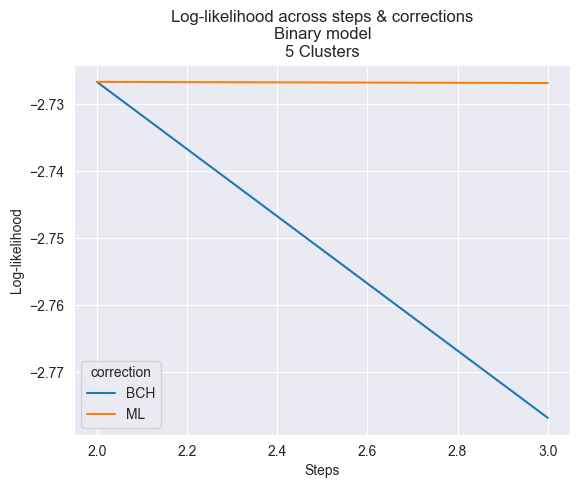

In [10]:
# Lower is better
sns.set_style("darkgrid")
sns.lineplot(data = result_binary_corr, 
             x = 'step', 
             y = 'log_likelihood',
             hue = 'correction')

# Add labels and title
plt.xlabel('Steps')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood across steps & corrections\n' 'Binary model\n' '5 Clusters')

In [11]:
# Run selected model
binary_cov_bch = StepMix(
            n_components=k, 
            n_steps=3, # loop over steps
            correction='BCH', # and loop over corrections
            measurement='binary_nan',   
            structural='covariate',
            verbose=0, 
            n_init=r,
            max_iter=m,
            random_state=seed
        )

binary_cov_bch.fit(X_bin, Z)

Fitting StepMix...


Initializations (n_init) : 100%|████████████████| 5/5 [03:26<00:00, 41.26s/it, max_LL=-1.74e+5, max_avg_LL=-2.73]


StepMix(correction='BCH', max_iter=3000, measurement='binary_nan',
        n_components=5, n_init=5, n_steps=3, random_state=240792,
        structural='covariate')

In [12]:
#Boostrap parameters
bs_params = binary_cov_bch.bootstrap_stats(X_bin, Z,
                                            n_repetitions=100)


Bootstrapping estimator...


Bootstrap Repetitions    : 100%|█| 100/100 [14:26:00<00:00, 519.61s/it, max_LL=-1.76e+5, median_LL=-1.77e+5, min_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stepmix/stepmix.py:1224: FutureWarning: The provided callable <function mean at 0x104939440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return pd.pivot_table(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stepmix/stepmix.py:1224: FutureWarning: The provided callable <function std at 0x104939580> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  return pd.pivot_table(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stepmix/stepmix.py:1224: FutureWarning: The provided callable <

In [13]:
level_header = ['model', 'model_name', 'param', 'class_no', 'variable']
bs_params['samples'].sort_index(level=level_header).index.unique()

MultiIndex([('measurement', 'binary_nan',  'pis', 0,    'clo_lca'),
            ('measurement', 'binary_nan',  'pis', 0,    'cnf_lca'),
            ('measurement', 'binary_nan',  'pis', 0,    'cnt_lca'),
            ('measurement', 'binary_nan',  'pis', 0,    'mon_lca'),
            ('measurement', 'binary_nan',  'pis', 0,    'sup_lca'),
            ('measurement', 'binary_nan',  'pis', 0,    'tra_lca'),
            ('measurement', 'binary_nan',  'pis', 1,    'clo_lca'),
            ('measurement', 'binary_nan',  'pis', 1,    'cnf_lca'),
            ('measurement', 'binary_nan',  'pis', 1,    'cnt_lca'),
            ('measurement', 'binary_nan',  'pis', 1,    'mon_lca'),
            ...
            ( 'structural',  'covariate', 'beta', 4,  'kin07_pgm'),
            ( 'structural',  'covariate', 'beta', 4,  'kin08_mgm'),
            ( 'structural',  'covariate', 'beta', 4,  'kin09_phs'),
            ( 'structural',  'covariate', 'beta', 4,  'kin10_mhs'),
            ( 'structural',  'co

In [14]:
# MEASUREMENT MODEL ##



samples = bs_params['samples']
samples

value  rep
model       model_name param class_no variable                 
measurement binary_nan pis   0        clo_lca     0.026642    0
                                      clo_lca     0.031453    1
                                      clo_lca     0.033823    2
                                      clo_lca     0.020586    3
                                      clo_lca     0.027364    4
...                                                    ...  ...
structural  covariate  beta  4        kin16_mcou -0.751104   95
                                      kin16_mcou  1.401557   96
                                      kin16_mcou  9.050209   97
                                      kin16_mcou  4.510614   98
                                      kin16_mcou  3.921302   99

[13500 rows x 2 columns]

/var/folders/4_/xdzhr_z915v28_2n49d3w5sh0000gn/T/ipykernel_9361/3742612817.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(
/var/folders/4_/xdzhr_z915v28_2n49d3w5sh0000gn/T/ipykernel_9361/3742612817.py:6: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.catplot(


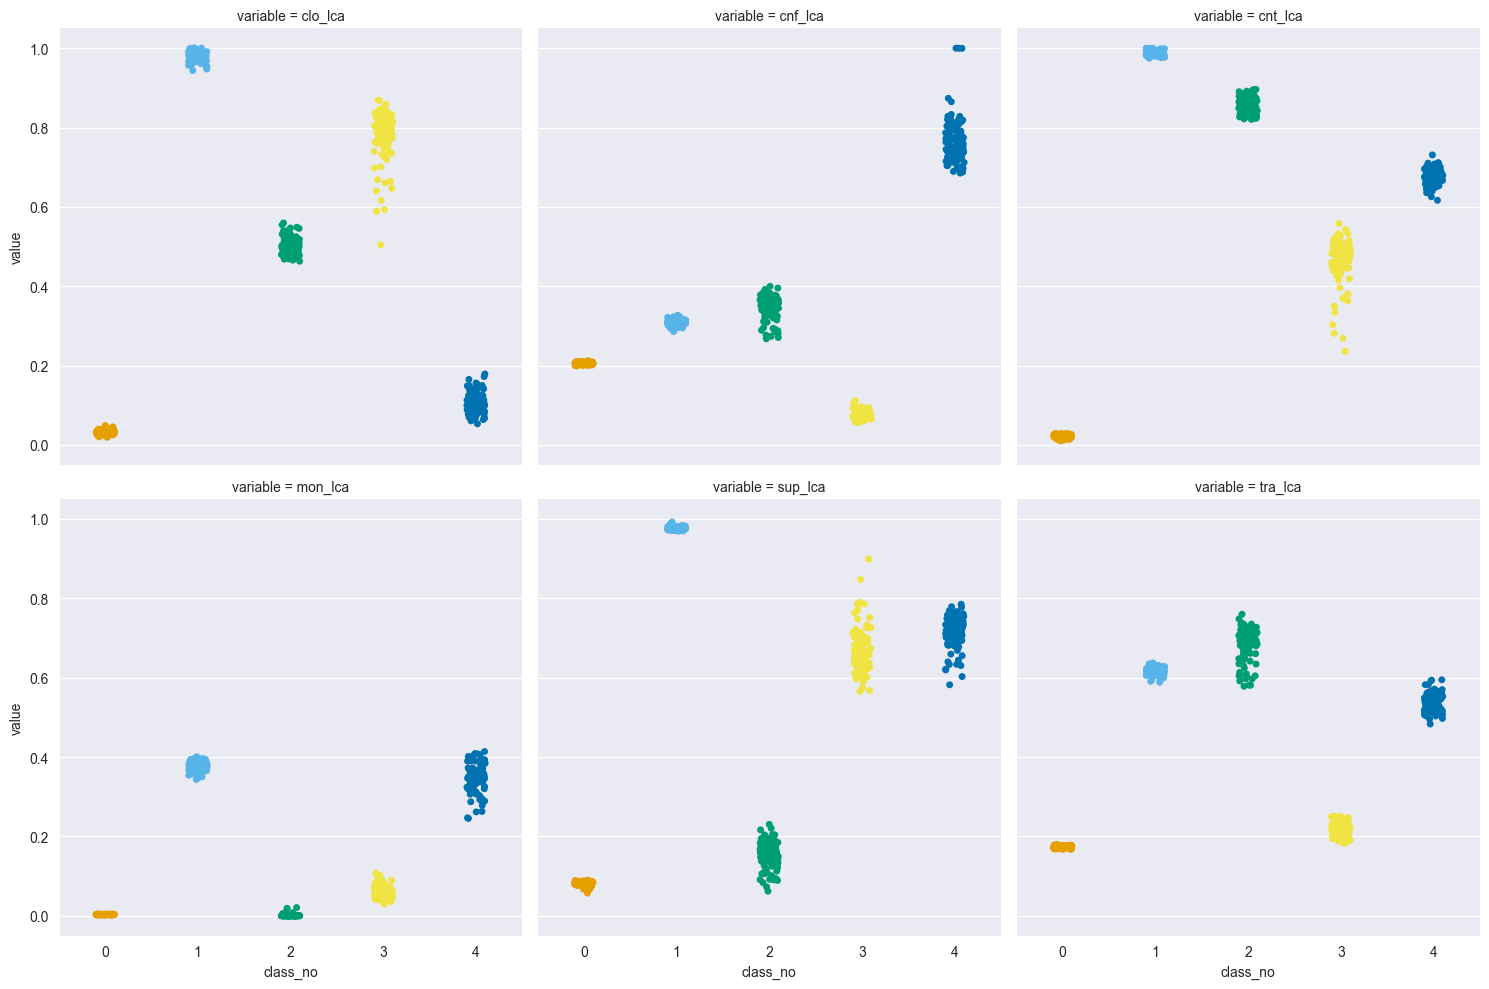

In [50]:
# Measurement (box plot)
# Okabe-Ito color palette (8 colors)
okabe_ito_colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000"]

# Measurement (box plot)
sns.catplot(
    data=samples.loc["measurement", "binary_nan", "pis"].reset_index(), 
    x="class_no", 
    y="value", 
    col="variable", 
    col_wrap=3, 
    kind="strip", # box for boxplot; strip for scatter; violin for violin
    palette=okabe_ito_colors  # Use Okabe-Ito color palette
)

# Show the plot
plt.show()

In [44]:
# STRUCTURAL MODEL ##


#Extract non-normalized betas
logit_1col = bs_params['samples'].xs("structural").iloc[:, 0]

#Create a DataFrame with bootstrapped betas as columns 
# per class 1 intercept and 20 slopes (21 betas) -> 5 classes * 21 parameters
logit_105cols = logit_1col.values.reshape([105, 100]).transpose()
logit_105cols = pd.DataFrame(logit_105cols)
 

In [18]:
logit_1col

model_name  param  class_no  variable  
covariate   beta   0         eth2_hisp     1.460980
                             eth2_hisp    -0.652593
                             eth2_hisp     0.024815
                             eth2_hisp     0.250769
                             eth2_hisp     0.151118
                                             ...   
                   4         kin16_mcou   -0.751104
                             kin16_mcou    1.401557
                             kin16_mcou    9.050209
                             kin16_mcou    4.510614
                             kin16_mcou    3.921302
Name: value, Length: 10500, dtype: float64

In [47]:
logit_105cols

,5,6,7,8,9,10,11,12,13,14,...,100,101,102,103,104,84,85,86,87,88
0,-44.516738,0.502750,0.552119,0.303780,0.161393,-0.020123,-0.083692,-0.032847,-0.096279,0.088233,...,-0.073903,0.305677,0.691129,0.928701,-13.338019,1.441035,-0.160654,-0.064903,-0.007411,-59.591838
1,29.405481,-0.227604,-0.117359,-0.166641,0.286357,0.027445,0.222563,0.061137,-0.079195,0.329923,...,0.165400,0.328692,-0.415383,-0.275663,6.312113,-0.639123,-0.054751,0.124142,-0.067021,36.407278
2,-2.750059,-0.038093,0.148255,0.053969,0.133876,0.079624,0.125472,-0.028279,-0.017933,0.300477,...,0.141806,0.076520,0.124540,0.135824,-0.827276,-0.001196,-0.124735,-0.067937,0.090813,-6.873088
3,11.750041,0.083242,0.121015,-0.041310,0.034643,0.128073,-0.001844,0.029088,0.108539,0.203069,...,0.079013,0.004451,-0.225498,-0.500121,2.585151,0.237004,-0.045888,-0.049769,0.064735,10.319483
4,7.108606,0.063900,-0.019459,-0.080276,0.248416,0.193858,0.134123,-0.016614,0.077421,0.191968,...,0.063105,0.064165,0.035300,-0.083891,0.823831,0.145056,-0.028139,-0.026737,0.062801,5.594778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.874175,-0.158494,0.004182,-0.023053,0.160116,0.086850,0.163869,-0.007697,0.068696,0.132311,...,0.047827,-0.045611,0.087553,-0.136149,-0.751104,0.135493,-0.007181,-0.006597,0.021691,-3.294963
96,7.889856,0.017330,-0.092457,-0.097244,0.174938,0.127131,0.098937,-0.147954,-0.182589,0.228223,...,0.143524,0.000454,-0.028965,-0.417601,1.401557,-0.004818,0.208385,0.030034,0.023933,7.686671
97,35.843691,-0.403816,-0.049483,-0.297349,0.109996,0.010830,-0.096109,-0.171528,0.054211,0.337769,...,0.228642,-0.215759,-0.505183,-1.149640,9.050209,0.069989,0.047282,0.114484,-0.073438,45.389317
98,18.360200,-0.072755,-0.386840,-0.258100,0.111539,-0.051063,-0.115641,-0.094367,-0.068603,0.123301,...,0.095949,0.136823,-0.091372,-1.288981,4.510614,-0.069830,0.327169,0.264338,0.107751,22.861287


In [46]:
#Change the order of the columns 
logit_105cols = pd.DataFrame(logit_105cols).iloc[:,
    [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,0,1,2,3,4,              #Class 0: Intercept, slopes kin, slopes eth
    26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,21,22,23,24,25,    #Class 1: Intercept, slope
    47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,42,43,44,45,46,    #Class 2: Intercept, slope
    68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,63,64,65,66,67,    #Class 3: Intercept, slope
    89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,84,85,86,87,88]]  #Class4 

In [51]:
#Create a DataFrame with the intercept and slope of the reference class times the number of classes
# Ref class: 0

#Create a DataFrame with the intercept and slope of the reference class times the number of latent classes
#(in original order!!)
logit_ref = pd.concat([logit_105cols.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]]] * 5, axis = 1)

# 0-105
#Change the labels of the DataFrames so that they fit each other
logit_ref.columns = range(0,105)
logit_105cols.columns = range(0,105)

#Subtract the reference class's betas from all classes' betas
normalized_beta = logit_105cols  - logit_ref #Add labels to help read the results


In [53]:
logit_105cols

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,-44.516738,0.502750,0.552119,0.303780,0.161393,-0.020123,-0.083692,-0.032847,-0.096279,0.088233,...,-0.073903,0.305677,0.691129,0.928701,-13.338019,1.441035,-0.160654,-0.064903,-0.007411,-59.591838
1,29.405481,-0.227604,-0.117359,-0.166641,0.286357,0.027445,0.222563,0.061137,-0.079195,0.329923,...,0.165400,0.328692,-0.415383,-0.275663,6.312113,-0.639123,-0.054751,0.124142,-0.067021,36.407278
2,-2.750059,-0.038093,0.148255,0.053969,0.133876,0.079624,0.125472,-0.028279,-0.017933,0.300477,...,0.141806,0.076520,0.124540,0.135824,-0.827276,-0.001196,-0.124735,-0.067937,0.090813,-6.873088
3,11.750041,0.083242,0.121015,-0.041310,0.034643,0.128073,-0.001844,0.029088,0.108539,0.203069,...,0.079013,0.004451,-0.225498,-0.500121,2.585151,0.237004,-0.045888,-0.049769,0.064735,10.319483
4,7.108606,0.063900,-0.019459,-0.080276,0.248416,0.193858,0.134123,-0.016614,0.077421,0.191968,...,0.063105,0.064165,0.035300,-0.083891,0.823831,0.145056,-0.028139,-0.026737,0.062801,5.594778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.874175,-0.158494,0.004182,-0.023053,0.160116,0.086850,0.163869,-0.007697,0.068696,0.132311,...,0.047827,-0.045611,0.087553,-0.136149,-0.751104,0.135493,-0.007181,-0.006597,0.021691,-3.294963
96,7.889856,0.017330,-0.092457,-0.097244,0.174938,0.127131,0.098937,-0.147954,-0.182589,0.228223,...,0.143524,0.000454,-0.028965,-0.417601,1.401557,-0.004818,0.208385,0.030034,0.023933,7.686671
97,35.843691,-0.403816,-0.049483,-0.297349,0.109996,0.010830,-0.096109,-0.171528,0.054211,0.337769,...,0.228642,-0.215759,-0.505183,-1.149640,9.050209,0.069989,0.047282,0.114484,-0.073438,45.389317
98,18.360200,-0.072755,-0.386840,-0.258100,0.111539,-0.051063,-0.115641,-0.094367,-0.068603,0.123301,...,0.095949,0.136823,-0.091372,-1.288981,4.510614,-0.069830,0.327169,0.264338,0.107751,22.861287


In [54]:
normalized_beta

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.073149,-0.089221,0.138146,-0.012601,0.053667,-0.019946,-0.003910,-0.088504,0.024490,0.169236
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.007229,-0.123378,-0.091437,-0.073475,-0.050064,0.013470,-0.015770,-0.004332,-0.015408,0.092866
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.014596,0.027696,0.006777,-0.073528,-0.006177,-0.026011,0.025279,-0.023173,0.018510,0.143366
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005218,-0.058371,-0.077205,-0.085908,-0.010165,-0.013766,-0.017962,-0.114554,0.121822,0.099705
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.024448,-0.049159,-0.055548,-0.078846,0.008530,-0.006061,-0.021515,-0.069762,0.051608,0.202241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.031114,-0.061290,0.091055,-0.003746,0.122680,0.048419,0.027853,-0.006832,0.044149,0.112458
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016549,0.019728,0.022032,0.010052,0.055005,0.050730,-0.019175,0.021495,0.013106,0.153509
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.199986,0.061467,0.067727,0.058488,0.054901,-0.028221,0.009887,-0.081993,0.000011,0.155771
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011535,0.112538,-0.021525,-0.019859,0.001586,-0.002302,0.047262,-0.063411,0.088918,0.143708


In [56]:
# Add labels to help read the results
Covariate_labels = ["NaN","NaN","NaN","NaN","NaN","NaN","NaN","NaN","NaN","NaN","NaN","NaN","NaN","NaN","NaN","NaN","NaN","NaN","NaN","NaN","NaN",
                    "C1_Intercept","C1_mother","C1_brother","C1_sister","C1_pgf","C1_mgf","C1_pgm","C1_mgm","C1_phs","C1_mhs","C1_pun","C1_mun","C1_pau","C1_mau","C1_pcou","C1_mcou","C1_eth_hisp","C1_eth_nhblack","C1_eth_nhasian","C1_eth_nhother","C1_female", #Labels for Bns of class 1
                    "C2_Intercept","C2_mother","C2_brother","C2_sister","C2_pgf","C2_mgf","C2_pgm","C2_mgm","C2_phs","C2_mhs","C2_pun","C2_mun","C2_pau","C2_mau","C2_pcou","C2_mcou","C2_eth_hisp","C2_eth_nhblack","C2_eth_nhasian","C2_eth_nhother","C2_female", #Labels for Bns of class 2
                    "C3_Intercept","C3_mother","C3_brother","C3_sister","C3_pgf","C3_mgf","C3_pgm","C3_mgm","C3_phs","C3_mhs","C3_pun","C3_mun","C3_pau","C3_mau","C3_pcou","C3_mcou","C3_eth_hisp","C3_eth_nhblack","C3_eth_nhasian","C3_eth_nhother","C3_female", #Labels for Bns of class 3
                    "C4_Intercept","C4_mother","C4_brother","C4_sister","C4_pgf","C4_mgf","C4_pgm","C4_mgm","C4_phs","C4_mhs","C4_pun","C4_mun","C4_pau","C4_mau","C4_pcou","C4_mcou","C4_eth_hisp","C4_eth_nhblack","C4_eth_nhasian","C4_eth_nhother","C4_female" #Labels for Bns of class 0] # 21 NaN for class 4 (REF)] #Labels for Bns of class 5
                   ]


#Bns and p-values
results = pd.DataFrame({"Coef": Covariate_labels,
              "mean": normalized_beta.apply(np.mean, axis = 0),
              "se": normalized_beta.apply(np.std, axis = 0),
              "z": normalized_beta.apply(np.mean, axis = 0)/normalized_beta.apply(np.std, axis = 0),
              "p-value": 2*norm.cdf(-np.abs(normalized_beta.apply(np.mean, axis = 0)/normalized_beta.apply(np.std, axis = 0))),
              "lb": normalized_beta.apply(np.mean, axis = 0) - 1.96 * normalized_beta.apply(np.std, axis = 0),
              "ub": normalized_beta.apply(np.mean, axis = 0) + 1.96 * normalized_beta.apply(np.std, axis = 0)}).round(3)

results

,Coef,mean,se,z,p-value,lb,ub
0,NaN,0.000,0.000,NaN,NaN,0.000,0.000
1,NaN,0.000,0.000,NaN,NaN,0.000,0.000
2,NaN,0.000,0.000,NaN,NaN,0.000,0.000
3,NaN,0.000,0.000,NaN,NaN,0.000,0.000
4,NaN,0.000,0.000,NaN,NaN,0.000,0.000
...,...,...,...,...,...,...,...
100,C4_eth_hisp,0.003,0.033,0.085,0.932,-0.062,0.067
101,C4_eth_nhblack,0.004,0.041,0.091,0.928,-0.076,0.084
102,C4_eth_nhasian,-0.027,0.058,-0.476,0.634,-0.141,0.086
103,C4_eth_nhother,0.049,0.086,0.573,0.567,-0.119,0.217


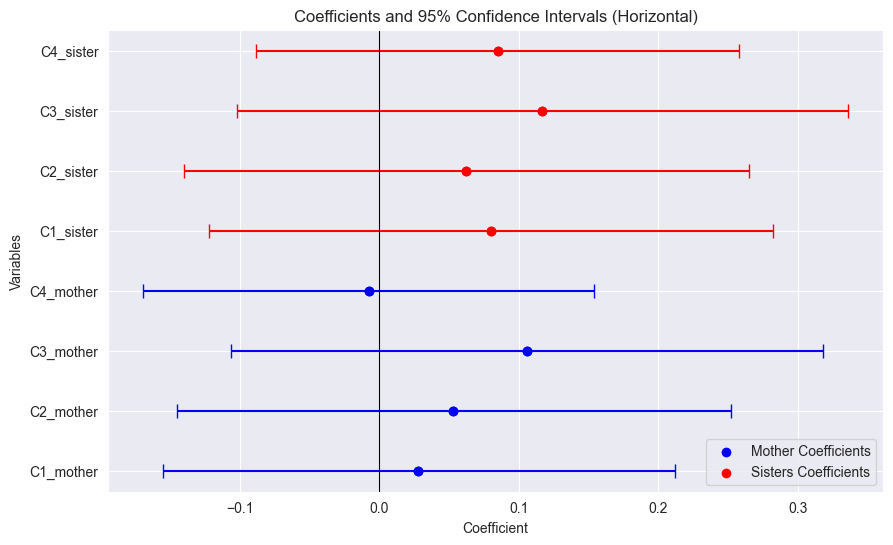

In [57]:
# 2. Filter the dataframe for '_mother' and '_sisters'
df_filtered = results[results['Coef'].str.contains('_mother') | results['Coef'].str.contains('_sister')]

# Custom order: First, all '_mother' variables, followed by all '_sisters' variables
mother_vars = df_filtered[df_filtered['Coef'].str.endswith('_mother')]['Coef'].tolist()
sister_vars = df_filtered[df_filtered['Coef'].str.endswith('_sister')]['Coef'].tolist()

# Combine them into the desired custom order
custom_order = mother_vars + sister_vars

# Sort the dataframe accordingly
df_sorted = df_filtered.set_index('Coef').reindex(custom_order).reset_index()

# Separate mother and sisters after sorting
df_mother = df_sorted[df_sorted['Coef'].str.endswith('_mother')]
df_sisters = df_sorted[df_sorted['Coef'].str.endswith('_sister')]

# Plot horizontal scatter plot for coefficients with confidence intervals
plt.figure(figsize=(10, 6))

# Plot for '_mother' coefficients (blue)
plt.scatter(df_mother['mean'], df_mother['Coef'], color='blue', label='Mother Coefficients')
plt.errorbar(df_mother['mean'], df_mother['Coef'], 
             xerr=[df_mother['mean'] - df_mother['lb'], df_mother['ub'] - df_mother['mean']], 
             fmt='o', color='blue', capsize=5)

# Plot for '_sisters' coefficients (red)
plt.scatter(df_sisters['mean'], df_sisters['Coef'], color='red', label='Sisters Coefficients')
plt.errorbar(df_sisters['mean'], df_sisters['Coef'], 
             xerr=[df_sisters['mean'] - df_sisters['lb'], df_sisters['ub'] - df_sisters['mean']], 
             fmt='o', color='red', capsize=5)

# Add labels and title
plt.ylabel('Variables')  # Coef will be on the y-axis
plt.xlabel('Coefficient')  # Mean and CI will be on the x-axis
plt.title('Coefficients and 95% Confidence Intervals (Horizontal)')
plt.axvline(0, color='black', linewidth=0.8)  # Add vertical line at 0

# Add legend to differentiate between mother and sister variables
plt.legend()

# Show the plot
plt.show()

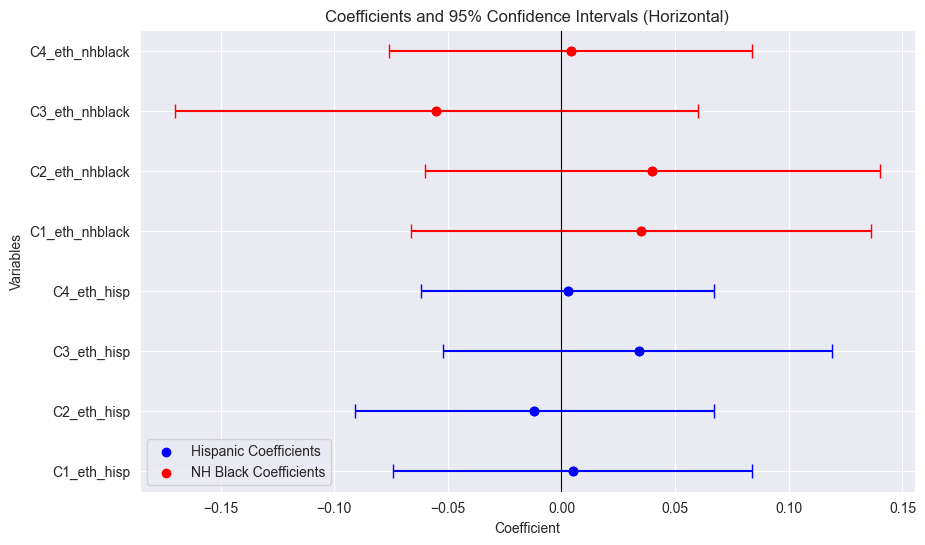

In [58]:
# 2. Filter the dataframe for '_mother' and '_sisters'
df_filtered = results[results['Coef'].str.contains('_eth')]

# Custom order: First, all '_mother' variables, followed by all '_sisters' variables
hisp_vars = df_filtered[df_filtered['Coef'].str.endswith('_hisp')]['Coef'].tolist()
nhblack_vars = df_filtered[df_filtered['Coef'].str.endswith('_nhblack')]['Coef'].tolist()

# Combine them into the desired custom order
custom_order = hisp_vars + nhblack_vars

# Sort the dataframe accordingly
df_sorted = df_filtered.set_index('Coef').reindex(custom_order).reset_index()

# Separate mother and sisters after sorting
df_hisp = df_sorted[df_sorted['Coef'].str.endswith('_hisp')]
df_nhblack = df_sorted[df_sorted['Coef'].str.endswith('_nhblack')]

# Plot horizontal scatter plot for coefficients with confidence intervals
plt.figure(figsize=(10, 6))

# Plot for '_mother' coefficients (blue)
plt.scatter(df_hisp['mean'], df_hisp['Coef'], color='blue', label='Hispanic Coefficients')
plt.errorbar(df_hisp['mean'], df_hisp['Coef'], 
             xerr=[df_hisp['mean'] - df_hisp['lb'], df_hisp['ub'] - df_hisp['mean']], 
             fmt='o', color='blue', capsize=5)

# Plot for '_sisters' coefficients (red)
plt.scatter(df_nhblack['mean'], df_nhblack['Coef'], color='red', label='NH Black Coefficients')
plt.errorbar(df_nhblack['mean'], df_nhblack['Coef'], 
             xerr=[df_nhblack['mean'] - df_nhblack['lb'], df_nhblack['ub'] - df_nhblack['mean']], 
             fmt='o', color='red', capsize=5)

# Add labels and title
plt.ylabel('Variables')  # Coef will be on the y-axis
plt.xlabel('Coefficient')  # Mean and CI will be on the x-axis
plt.title('Coefficients and 95% Confidence Intervals (Horizontal)')
plt.axvline(0, color='black', linewidth=0.8)  # Add vertical line at 0

# Add legend to differentiate between mother and sister variables
plt.legend()

# Show the plot
plt.show()

In [48]:
# Export dataframe to csv
logit_1col.to_csv('../data/logit_1col5.csv')

In [34]:
# Export dataframe to csv
logit_132cols.to_csv('../data/logit_132cols.csv')